## KP Slc4a11-MCD mTmG traced mice
2/29/2024 - Data generated from 12 week KP Slc4a11-MCD mTmG mice; data submitted by CHP/EB/JC on 1/26/2024, analyzed by JC 2/29/2024

8/25/2025 - Rerun analysis with updated libraries, for coherence

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib

import anndata
from pathlib import Path

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/IGO15600-mTmG-12week.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_h5('GSE277777_IGO15600-filtered_feature_bc_matrix.h5', gex_only=False)

reading GSE277777_IGO15600-filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/chanj2/opt/miniconda3/envs/part1-cellrank-geo/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [8]:
print(samples)

['BF1303_B0301_GFP+', 'BD1621_B0302_GFP+', 'BD1623_B0303_Live+Dump-_Carrier', 'BD1940_B0304_mKate2+']


In [9]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [10]:
hashadata.var

gene_ids  \
BF1303_B0301_GFP+                              BF1303_B0301_GFP+   
BD1621_B0302_GFP+                              BD1621_B0302_GFP+   
BD1623_B0303_Live+Dump-_Carrier  BD1623_B0303_Live+Dump-_Carrier   
BD1940_B0304_mKate2+                        BD1940_B0304_mKate2+   

                                    feature_types genome  \
BF1303_B0301_GFP+                Antibody Capture          
BD1621_B0302_GFP+                Antibody Capture          
BD1623_B0303_Live+Dump-_Carrier  Antibody Capture          
BD1940_B0304_mKate2+             Antibody Capture          

                                                   pattern read  \
BF1303_B0301_GFP+                5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
BD1621_B0302_GFP+                5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
BD1623_B0303_Live+Dump-_Carrier  5PNNNNNNNNNN(BC)NNNNNNNNN   R2   
BD1940_B0304_mKate2+             5PNNNNNNNNNN(BC)NNNNNNNNN   R2   

                                        sequence  
BF1303_B0301_GFP+                ACCCACCAGTAAGAC  
BD1621_B0302_GFP+                GGTCGAGAGCATTCA  
BD1623_B0303_Live+Dump-_Carrier  CTTGCCGCATGTCAT  
BD1940_B0304_mKate2+             AAAGCATTCTTCACG

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/part1-cellrank-geo/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


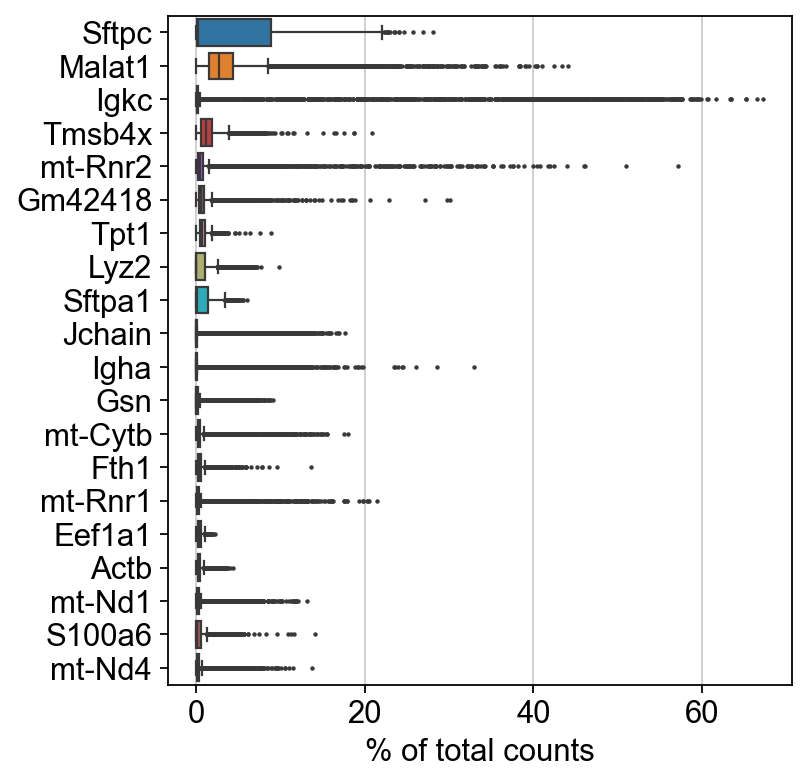

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [12]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1488 cells that have less than 1500 counts
filtered out 2 cells that have less than 300 genes expressed
filtered out 29477 genes that are detected in less than 3 cells


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([2.000e+00, 1.600e+01, 1.470e+02, 3.040e+02, 2.330e+02, 5.920e+02,
        1.964e+03, 3.951e+03, 3.026e+03, 2.760e+02]),
 array([0.70886262, 0.73265116, 0.7564397 , 0.78022823, 0.80401677,
        0.82780531, 0.85159384, 0.87538238, 0.89917092, 0.92295945,
        0.94674799]),
 <BarContainer object of 10 artists>)

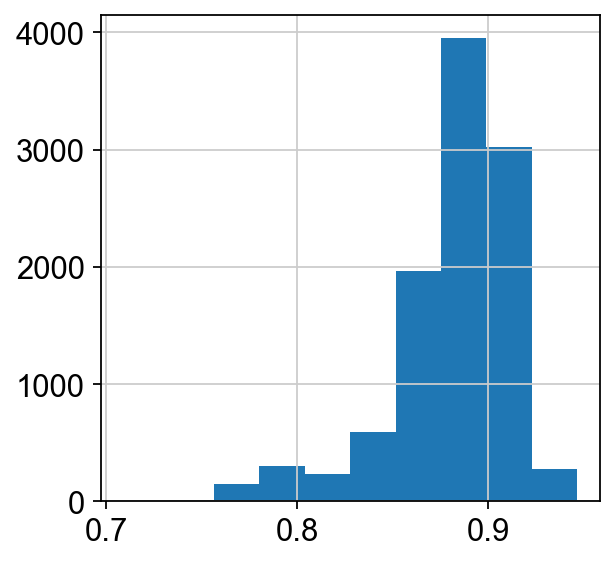

In [15]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

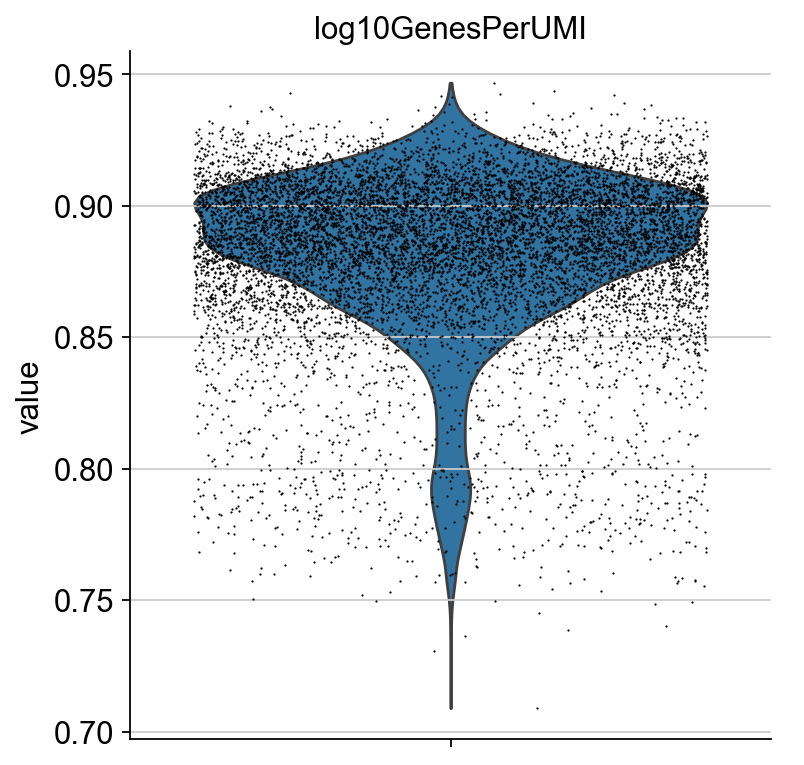

In [16]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

In [17]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [18]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [19]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [20]:
hashadata.var_names

Index(['BF1303_B0301_GFP+', 'BD1621_B0302_GFP+',
       'BD1623_B0303_Live+Dump-_Carrier', 'BD1940_B0304_mKate2+'],
      dtype='object')

In [21]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [22]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

BF1303_B0301_GFP+  BD1621_B0302_GFP+  BD1623_B0303_Live+Dump-_Carrier  \
count       10048.000000       10048.000000                     10048.000000   
mean          151.841766          23.448248                       641.614563   
std           534.716492         257.549835                      1088.568481   
min             0.000000           0.000000                         2.000000   
10%            33.000000           0.000000                        47.000000   
20%            38.000000           1.000000                        63.000000   
30%            42.000000           1.000000                        90.000000   
40%            46.000000           2.000000                       139.000000   
50%            50.000000           2.000000                       226.000000   
60%            55.000000           3.000000                       382.200000   
70%            61.000000           3.000000                       626.000000   
80%            74.000000           4.000000                       980.000000   
90%           210.000000           6.000000                      1655.300000   
99%          2250.190000         493.300000                      5226.360000   
max         16645.000000        8724.000000                     20893.000000   

       BD1940_B0304_mKate2+  
count          10048.000000  
mean             212.757965  
std              640.683777  
min                0.000000  
10%                8.000000  
20%               11.000000  
30%               13.000000  
40%               15.000000  
50%               17.000000  
60%               21.000000  
70%               27.000000  
80%               55.000000  
90%              653.600000  
99%             3086.650000  
max            12394.000000

In [23]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
hashIDs

BF1303_B0301_GFP+
210.0
BD1621_B0302_GFP+
6.0
BD1623_B0303_Live+Dump-_Carrier
1655.300000000001
BD1940_B0304_mKate2+
653.6000000000022


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False  True]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/2942643048.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

BF1303_B0301_GFP+  BD1621_B0302_GFP+  \
AAACCCAAGGAAGTAG-1              False              False   
AAACCCAAGGAATTAC-1              False              False   
AAACCCAAGTCGAATA-1              False              False   
AAACCCAAGTTTGCTG-1              False              False   
AAACCCACACAAAGCG-1              False              False   
...                               ...                ...   
TTTGTTGGTCGTATGT-1              False              False   
TTTGTTGGTTCGGTCG-1              False              False   
TTTGTTGTCGGCAGTC-1              False              False   
TTTGTTGTCTATGCCC-1              False              False   
TTTGTTGTCTCCCTAG-1              False               True   

                    BD1623_B0303_Live+Dump-_Carrier  BD1940_B0304_mKate2+  
AAACCCAAGGAAGTAG-1                            False                 False  
AAACCCAAGGAATTAC-1                            False                 False  
AAACCCAAGTCGAATA-1                            False                 False  
AAACCCAAGTTTGCTG-1                            False                 False  
AAACCCACACAAAGCG-1                             True                 False  
...                                             ...                   ...  
TTTGTTGGTCGTATGT-1                            False                 False  
TTTGTTGGTTCGGTCG-1                            False                 False  
TTTGTTGTCGGCAGTC-1                            False                 False  
TTTGTTGTCTATGCCC-1                            False                 False  
TTTGTTGTCTCCCTAG-1                            False                 False  

[10048 rows x 4 columns]

In [24]:
from matplotlib import pyplot as plt

In [25]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank-geo/lib/python3.11/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


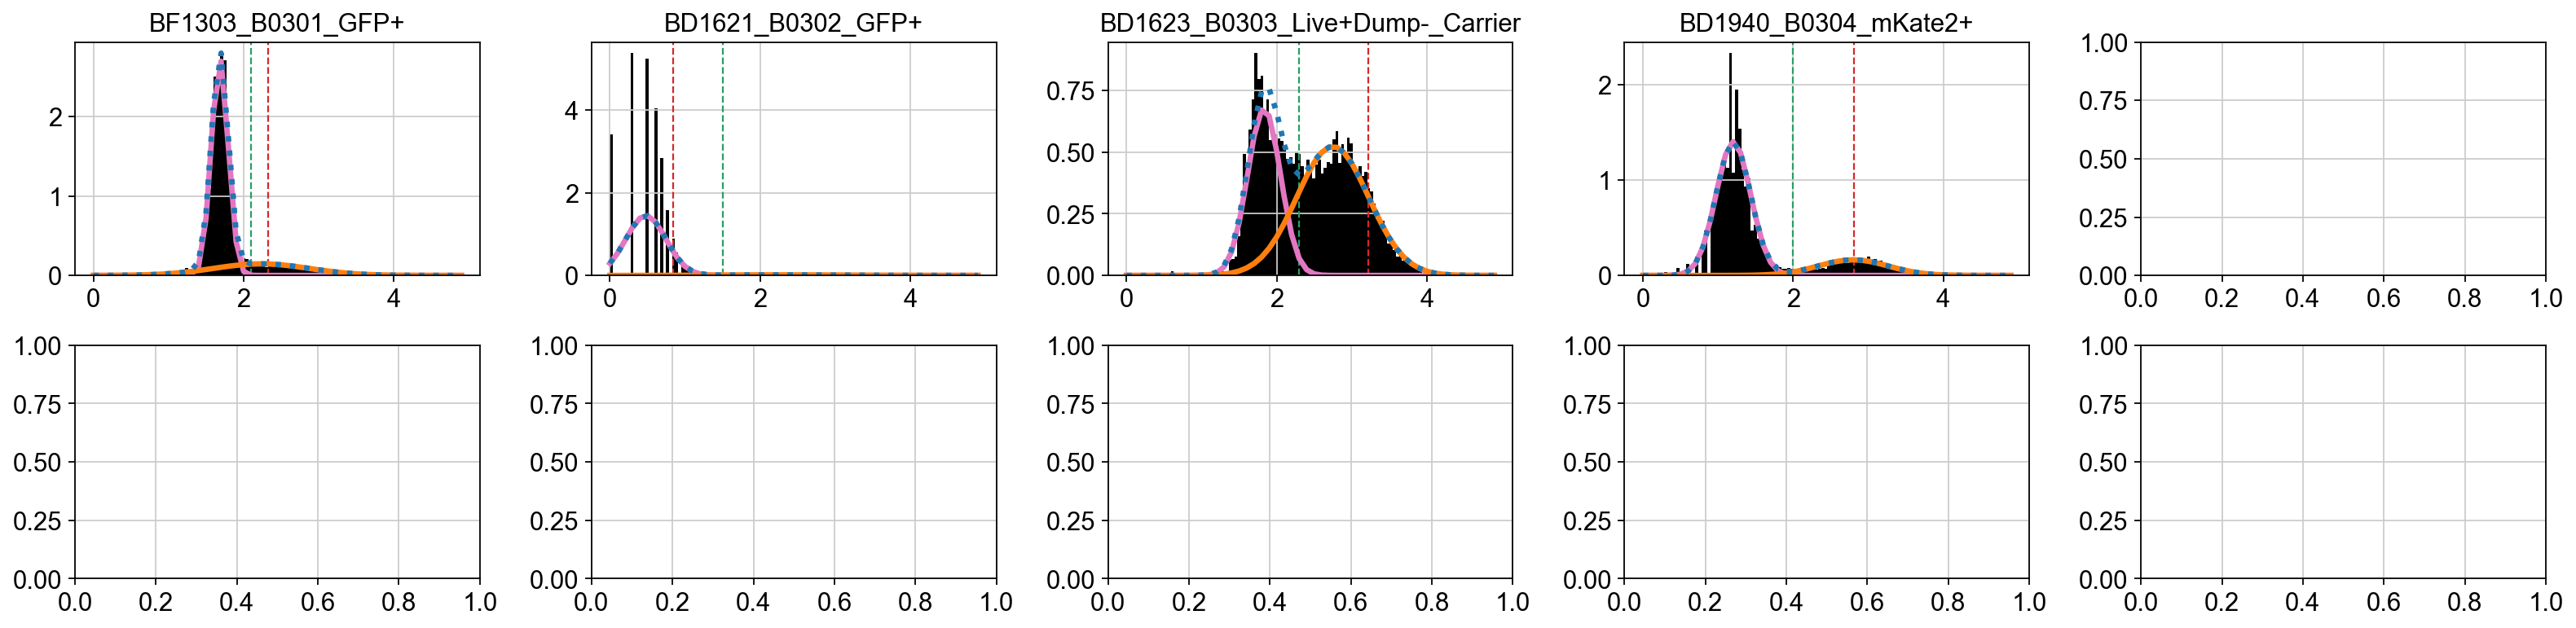

In [26]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]    
    if mean[0][0] < mean[1][0]:
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [27]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BF1303_B0301_GFP+
2.1
BD1621_B0302_GFP+
1.5
BD1623_B0303_Live+Dump-_Carrier
2.3000000000000003
BD1940_B0304_mKate2+
2.0


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/416796475.py:6: FutureWarning: Setting an item of incompati

In [28]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    #print(i)
    #print(hashBool)
    #print(hashBool.values)
    #print(sum(hashBool))
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [29]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BD1623_B0303_Live+Dump-_Carrier    4643
negative                           2203
BD1940_B0304_mKate2+               1371
BF1303_B0301_GFP+                   949
doublet                             734
BD1621_B0302_GFP+                   148
Name: count, dtype: int64

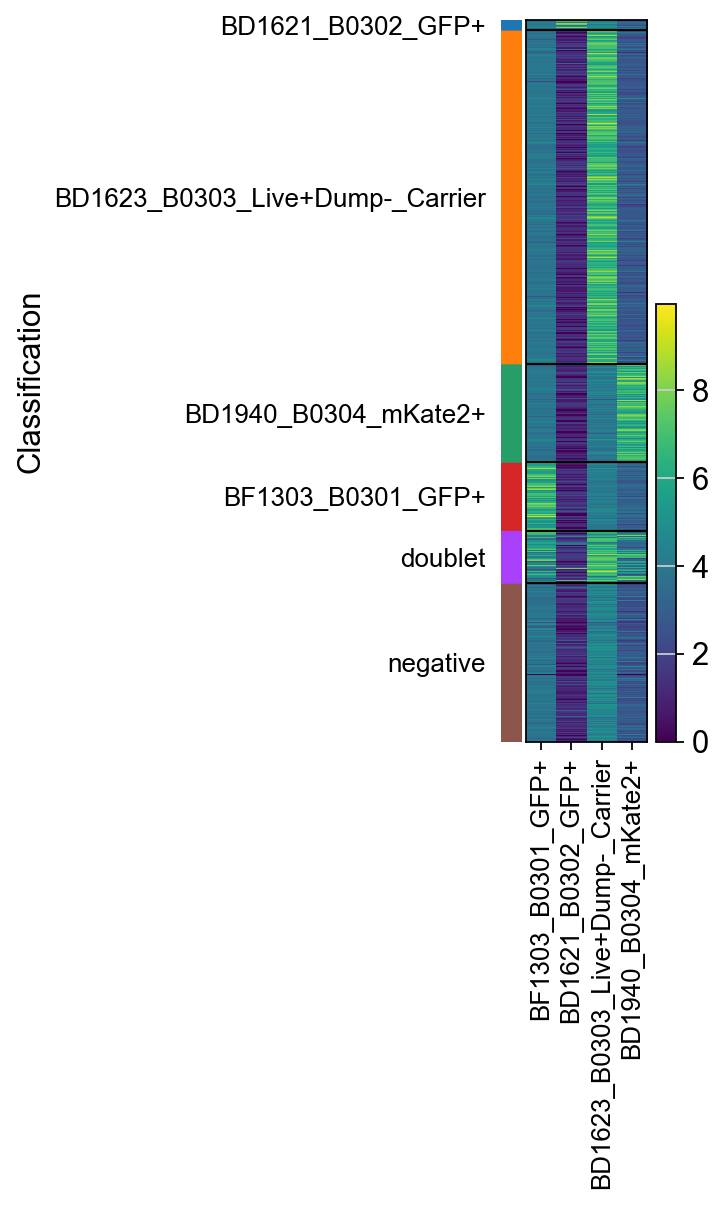

In [30]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## Setup transgenes counts

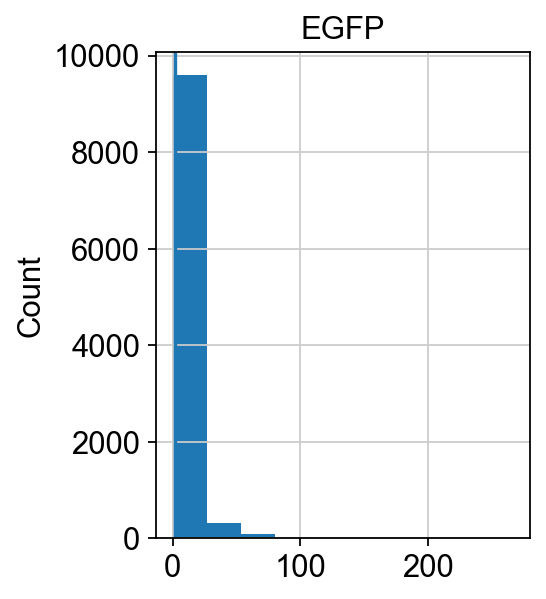

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [32]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

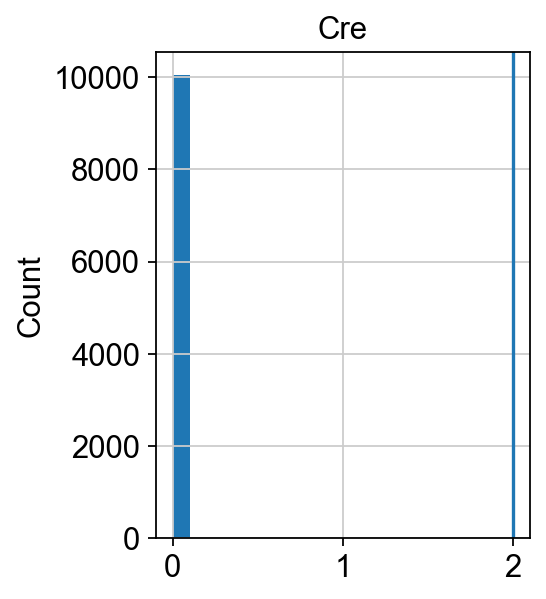

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [34]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

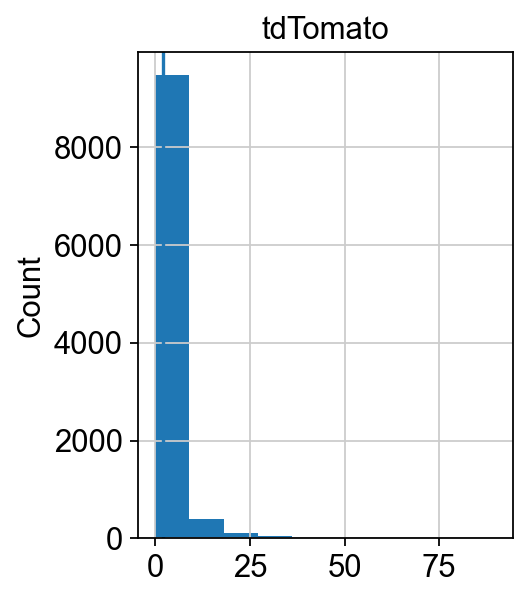

In [35]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [36]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

## Filter doublets and negative cells

In [37]:
adata.obs.Classification.value_counts()

Classification
BD1623_B0303_Live+Dump-_Carrier    4643
negative                           2203
BD1940_B0304_mKate2+               1371
BF1303_B0301_GFP+                   949
doublet                             734
BD1621_B0302_GFP+                   148
Name: count, dtype: int64

In [38]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [39]:
adata.obs.Classification.value_counts()

Classification
BD1623_B0303_Live+Dump-_Carrier    4643
BD1940_B0304_mKate2+               1371
BF1303_B0301_GFP+                   949
BD1621_B0302_GFP+                   148
Name: count, dtype: int64

In [40]:
samples

['BF1303_B0301_GFP+',
 'BD1621_B0302_GFP+',
 'BD1623_B0303_Live+Dump-_Carrier',
 'BD1940_B0304_mKate2+']

## Run basic normaliztaions

In [41]:
adata.layers['counts']=adata.X.copy()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/1857676282.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts']=adata.X.copy()


In [42]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [43]:
sc.pp.log1p(adata)

In [44]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [45]:
sc.pl.highly_variable_genes(adata)

In [46]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/8505131

In [47]:
adata.write('write/allmice-IGO15600.h5ad', compression='gzip')

In [48]:
sc.pp.scale(adata, max_value=10)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank-geo/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [49]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:04)


In [50]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

Save the result.

In [51]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [52]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=70)

computing neighbors
    using 'X_pca' with n_pcs = 70
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


## Embedding the neighborhood graph

In [53]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


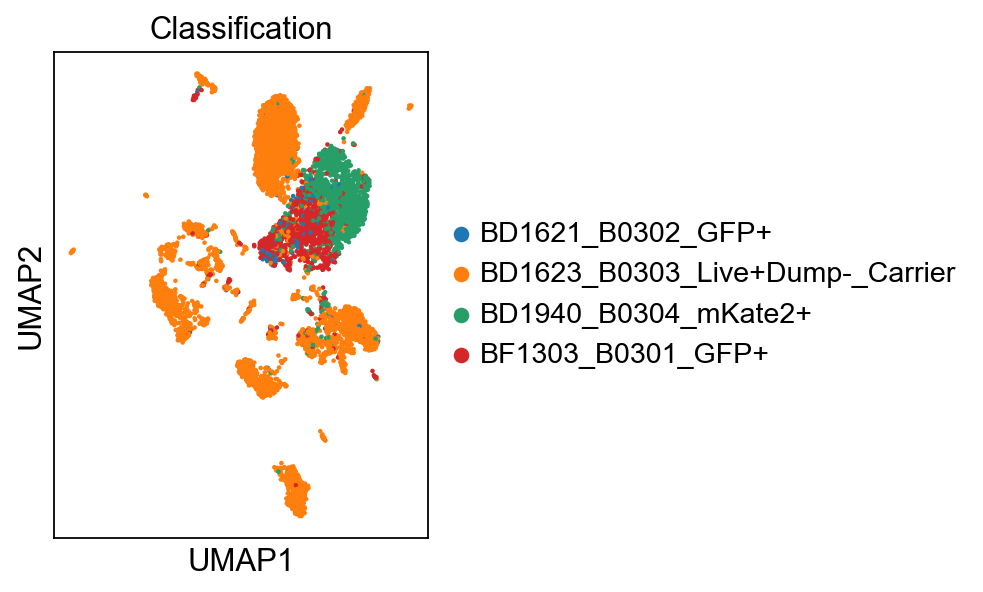

In [54]:
sc.pl.umap(adata, color=['Classification'])

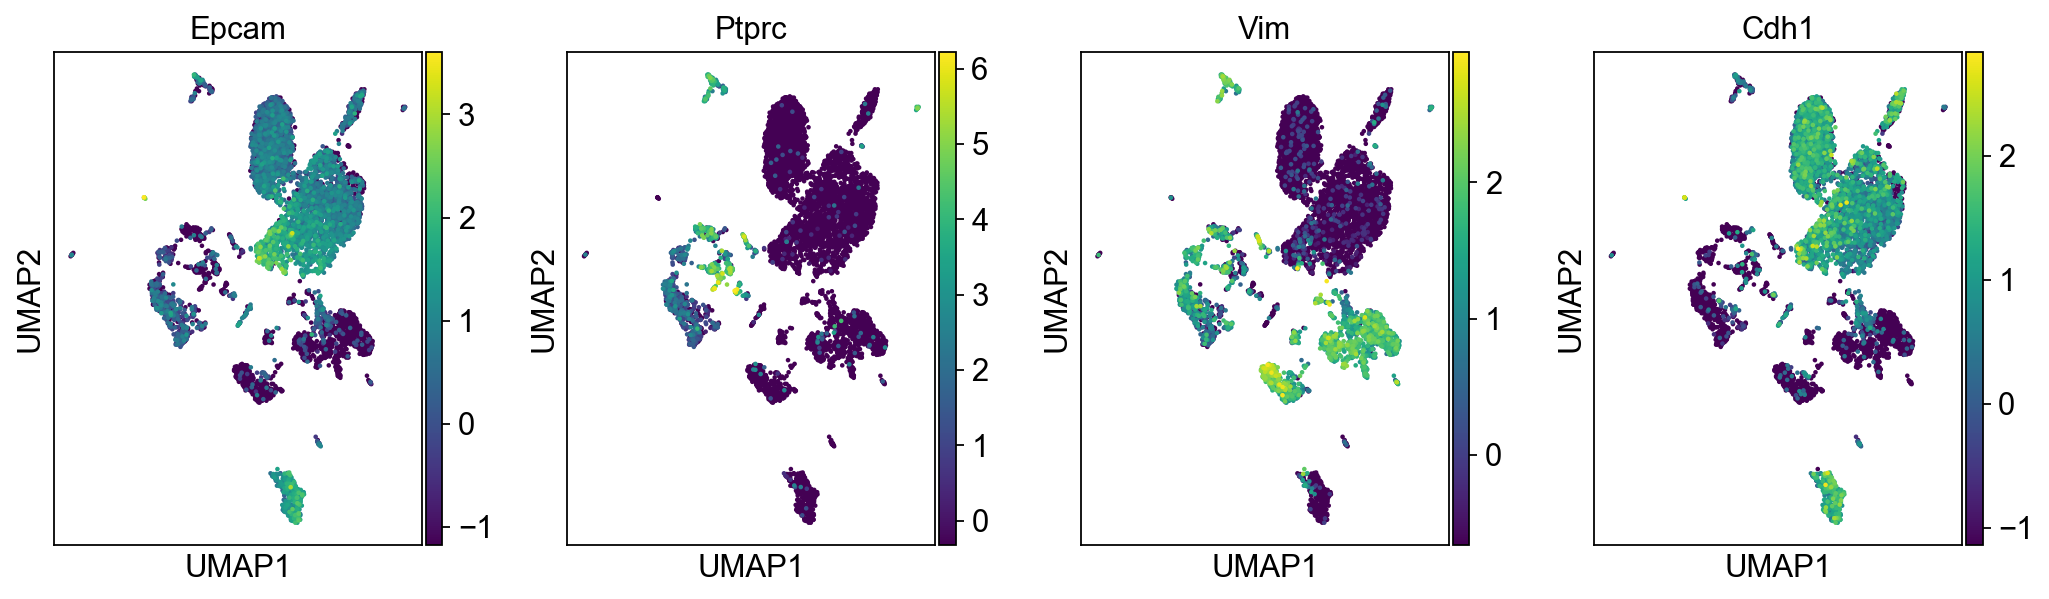

In [55]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

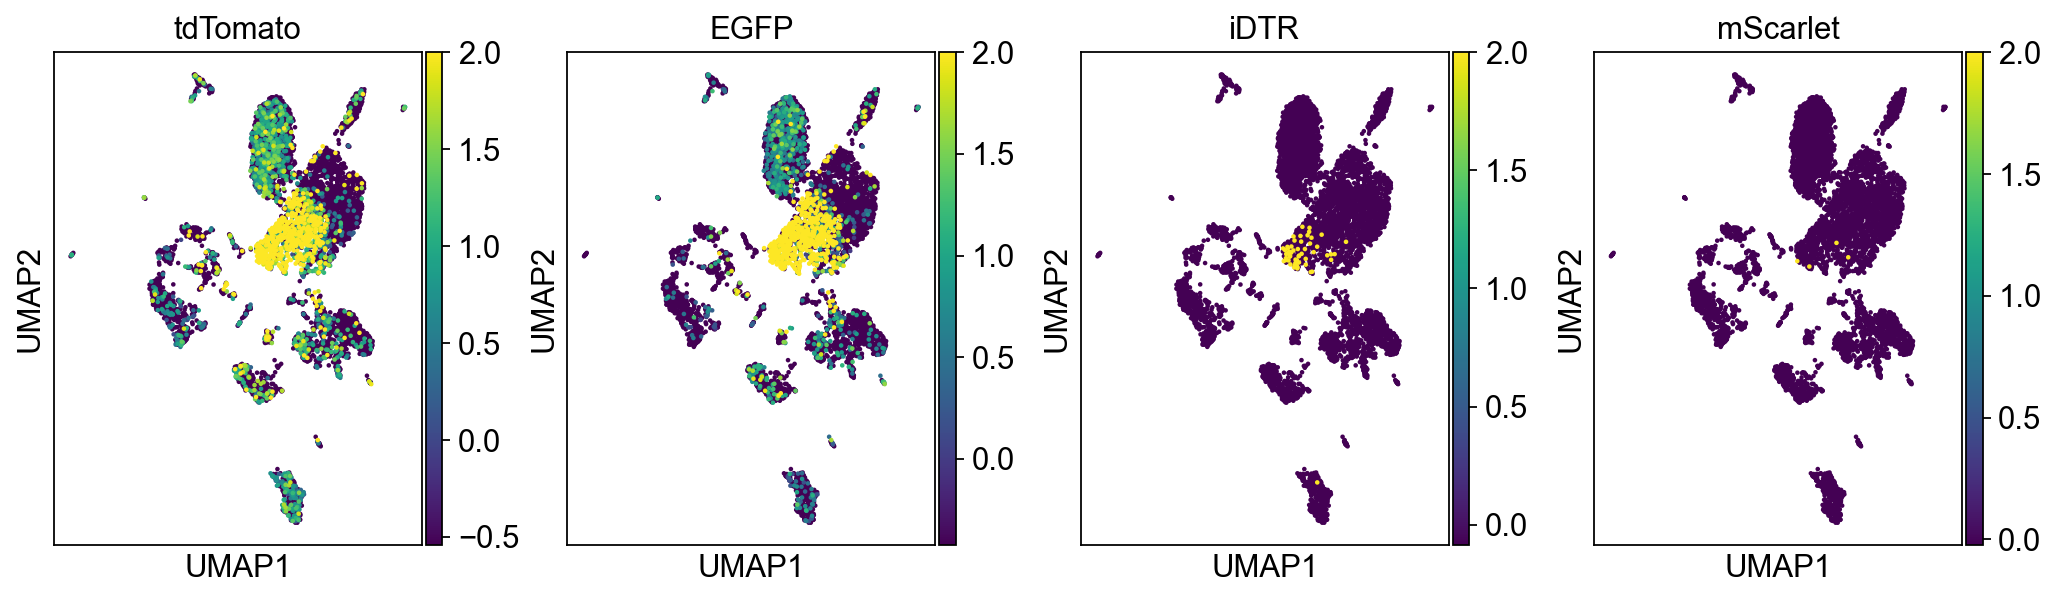

In [56]:
sc.pl.umap(adata, color=['tdTomato','EGFP','iDTR','mScarlet'], vmax=2)

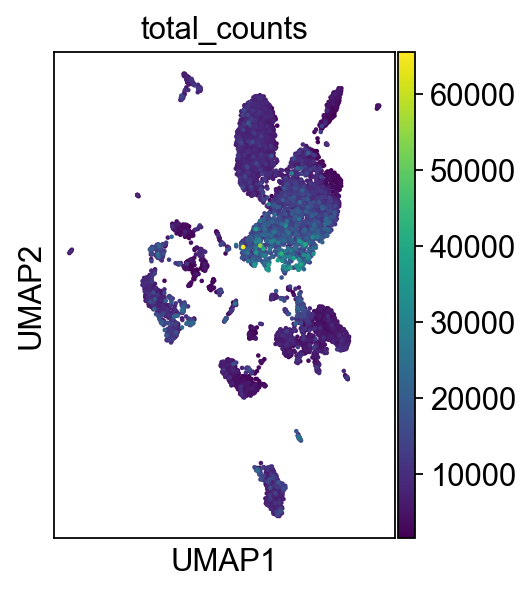

In [57]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [58]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [59]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [60]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1588 total control genes are used. (0:00:01)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1290 total control genes are used. (0:00:01)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1596 total control genes are used. (0:00:01)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1594 total control genes are used. (0:00:01)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1989 total control genes are used. (0:00:01)
computing score 'Cluster 6'
       'Gm6139', 'Gm10179', 'Ldha-ps2', 'Gm5864'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2190 total control genes are used. (0:00:01)
computing score 'Cluster 7'
    finished: added
    'Clus

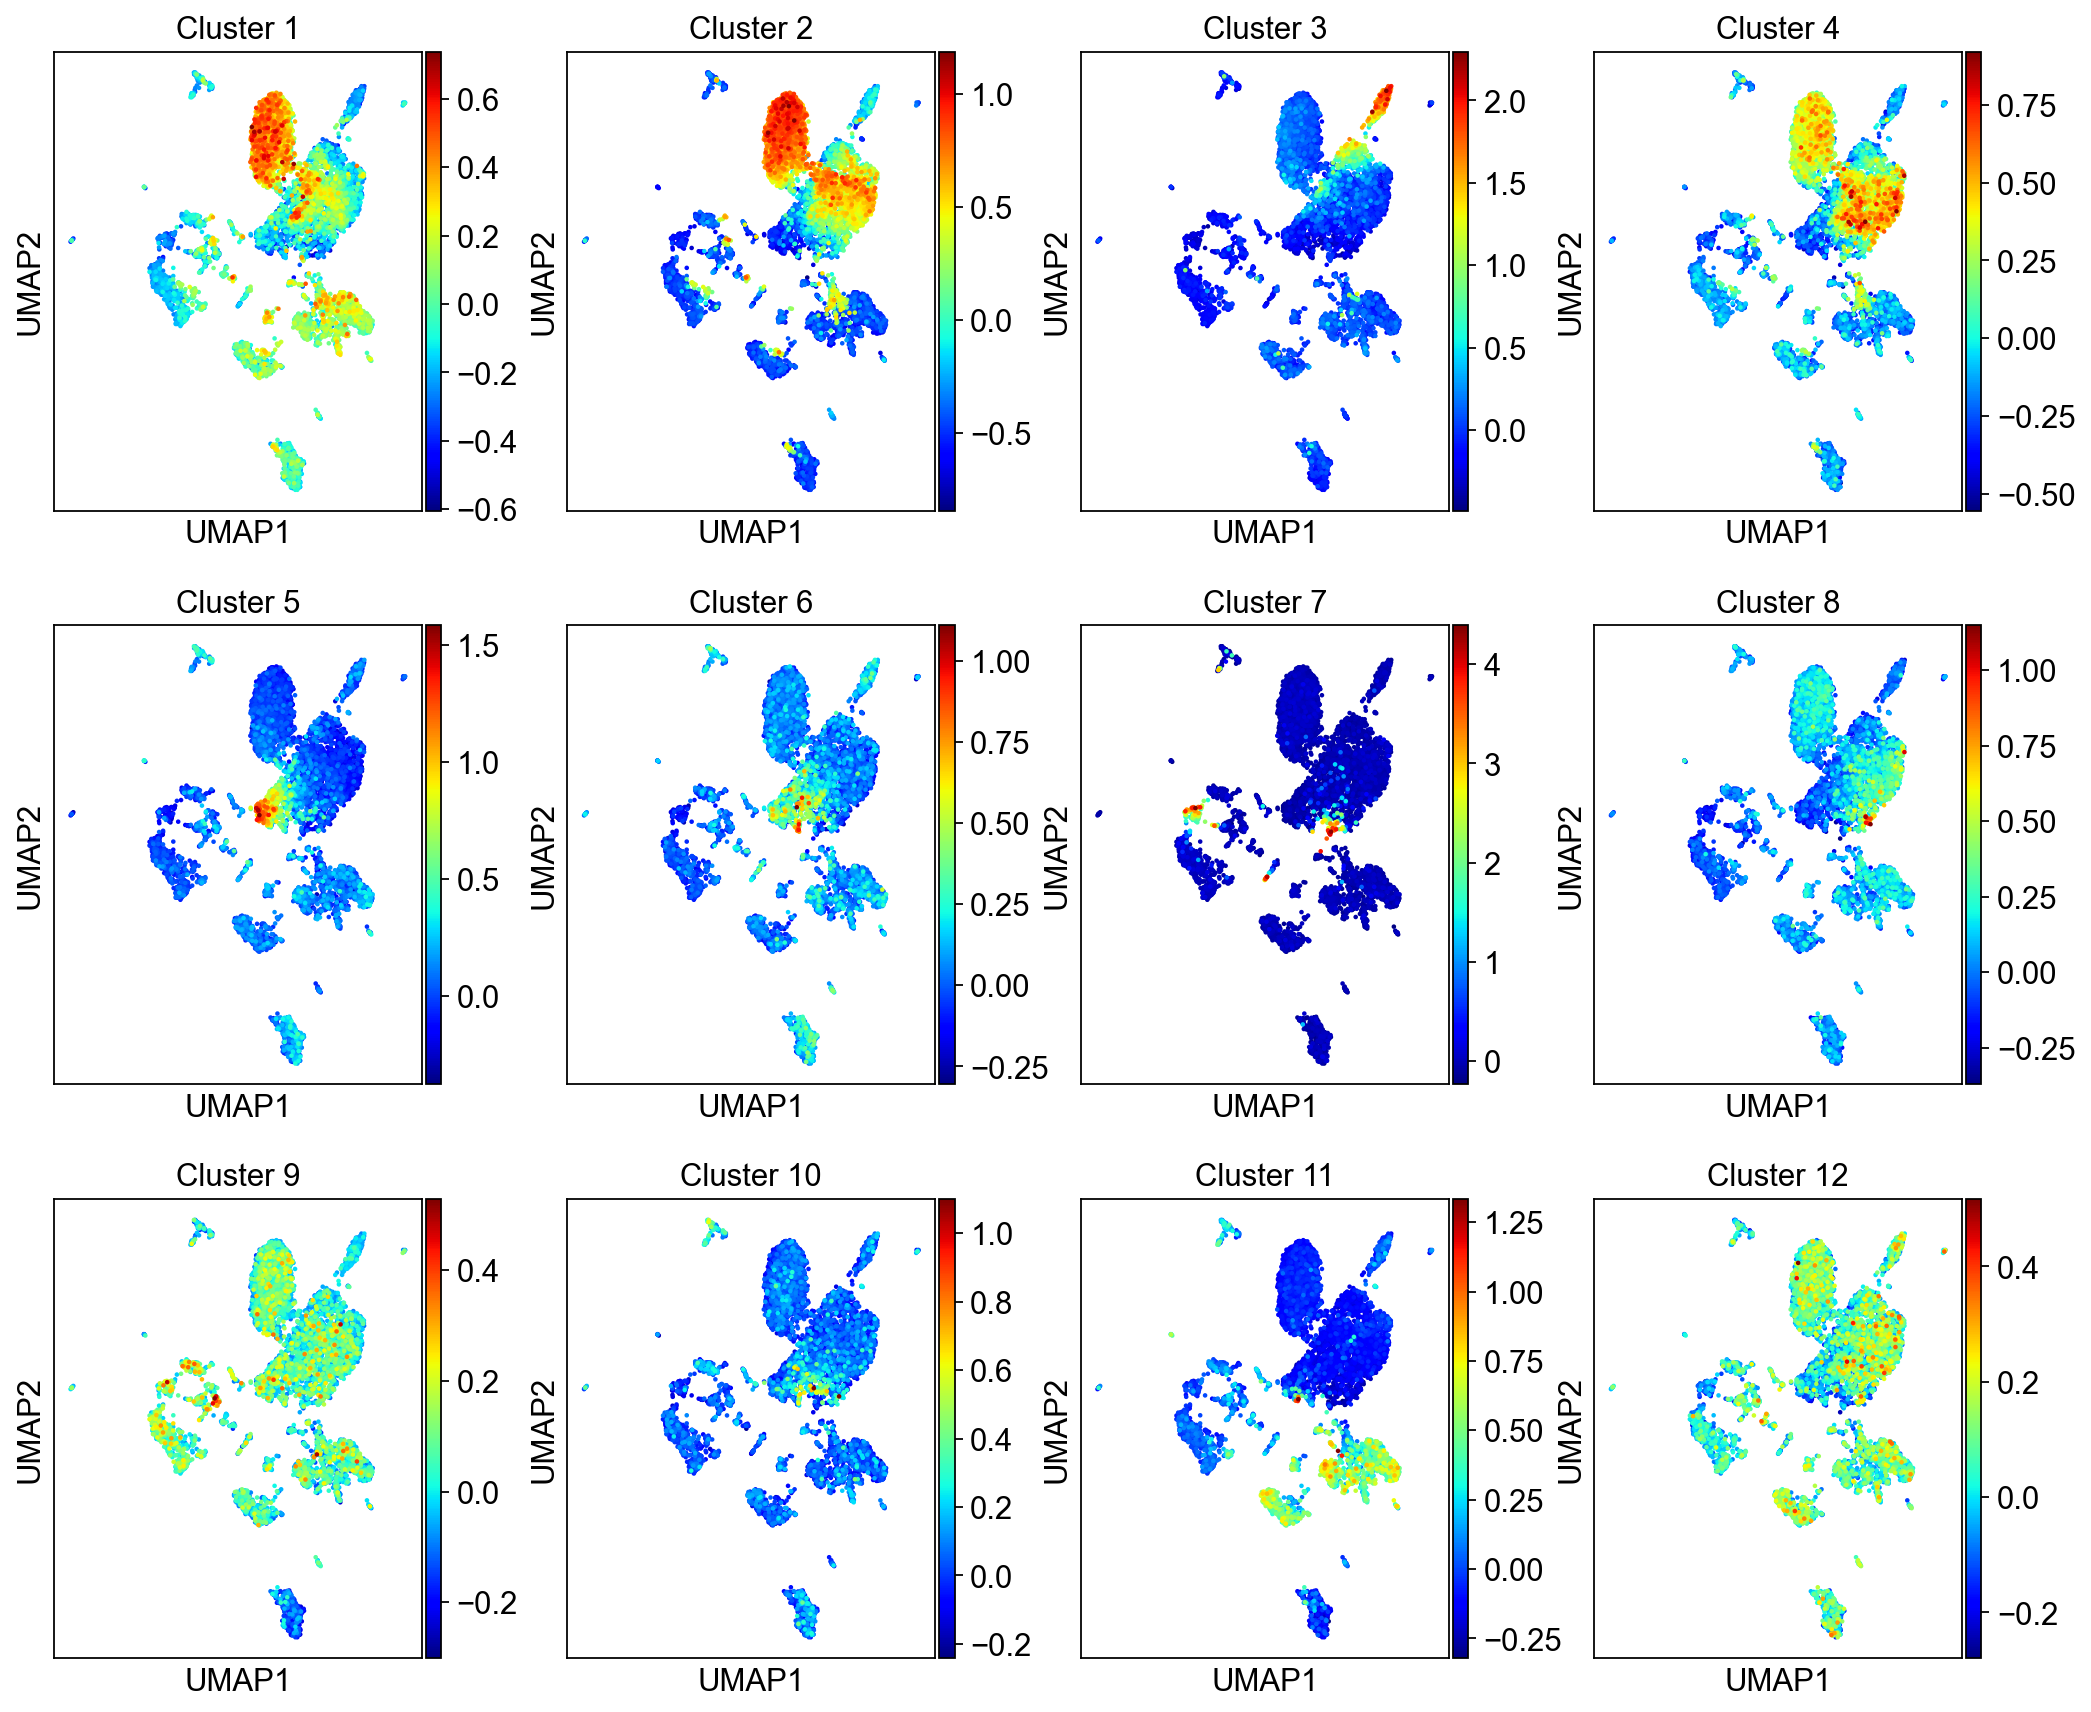

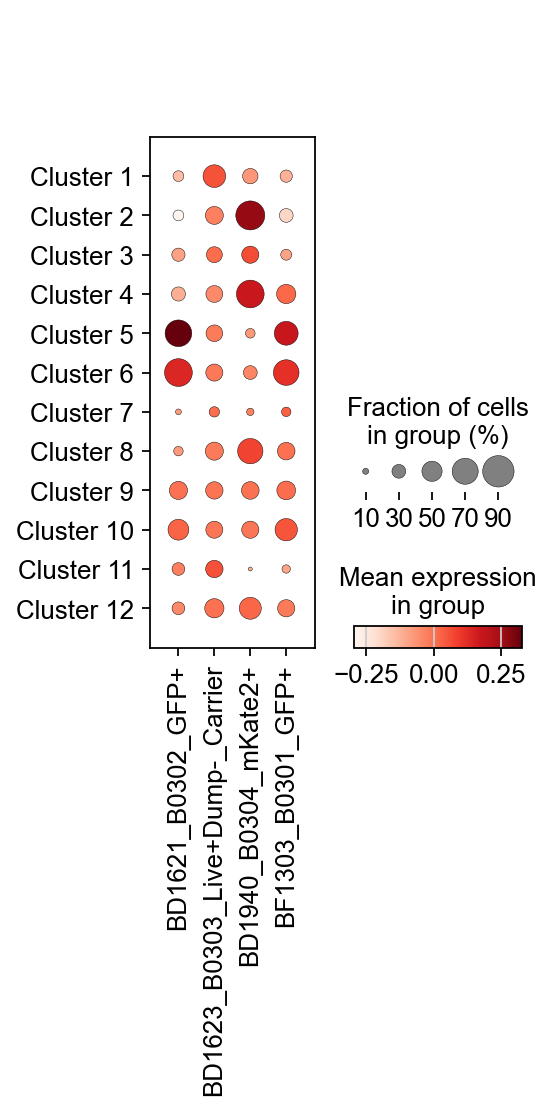

In [61]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [62]:
sc.tl.leiden(adata, resolution=0.3)

running Leiden clustering


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/3347713724.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

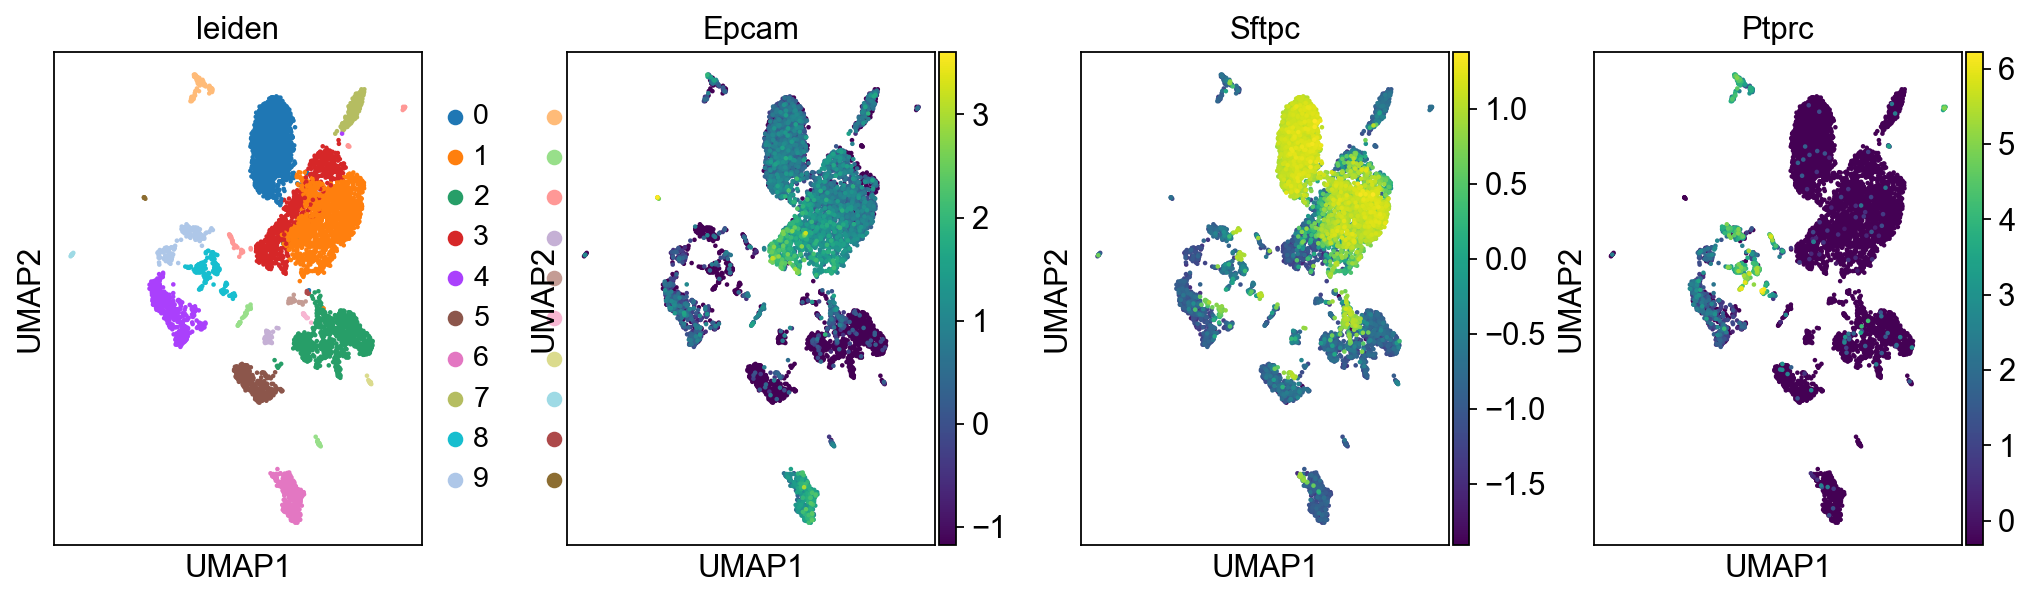

(None,)

In [63]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

In [64]:
sc.pl.umap(adata, color=['Kras',  'Zeb2', ]) #'Cd109', #'Sox11'

Save the result.

In [65]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

In [66]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

In [67]:
sc.pl.umap(adata, color=['EGFP'], cmap='Reds')
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')

In [68]:
adata

AnnData object with n_obs × n_vars = 7111 × 25368
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'EGFP_count', 'Cre_count', 'tdTomato_count', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Classification_colors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

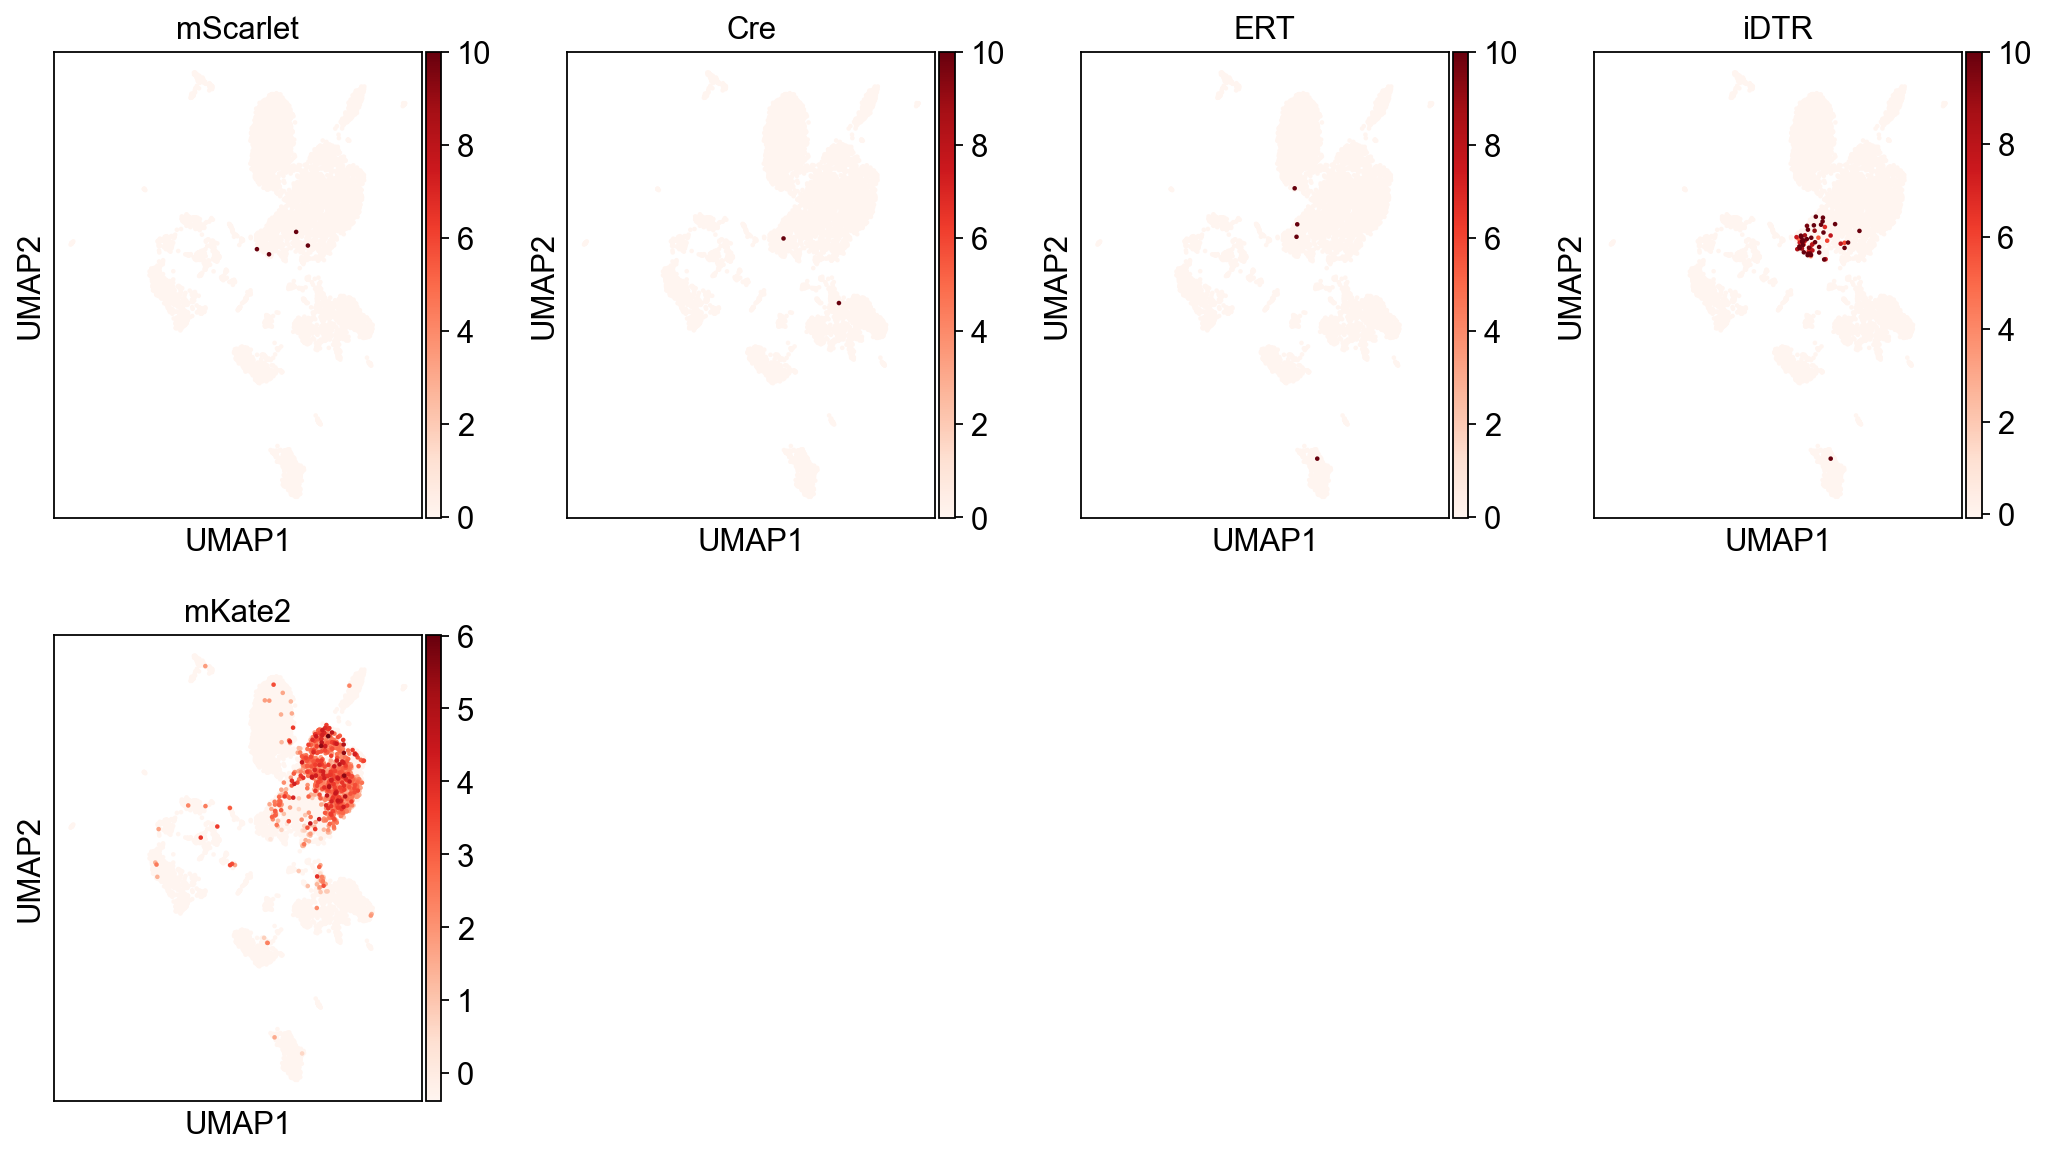

In [69]:
sc.pl.umap(adata, color=["mScarlet", "Cre", "ERT",'iDTR','mKate2'], cmap='Reds')

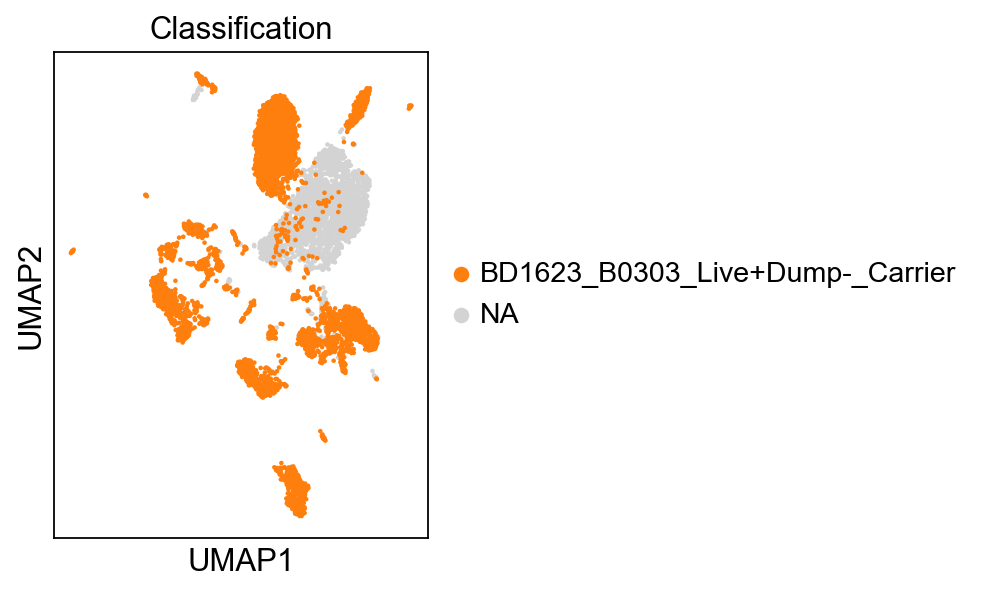

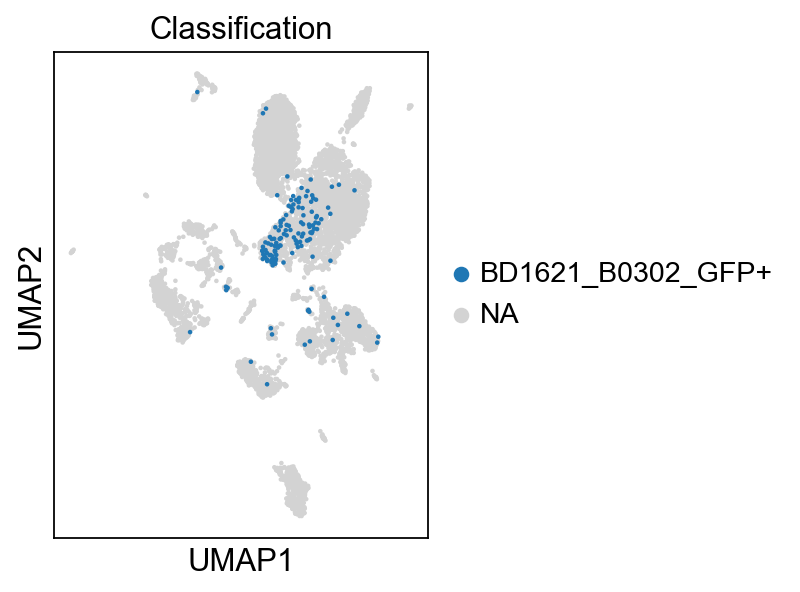

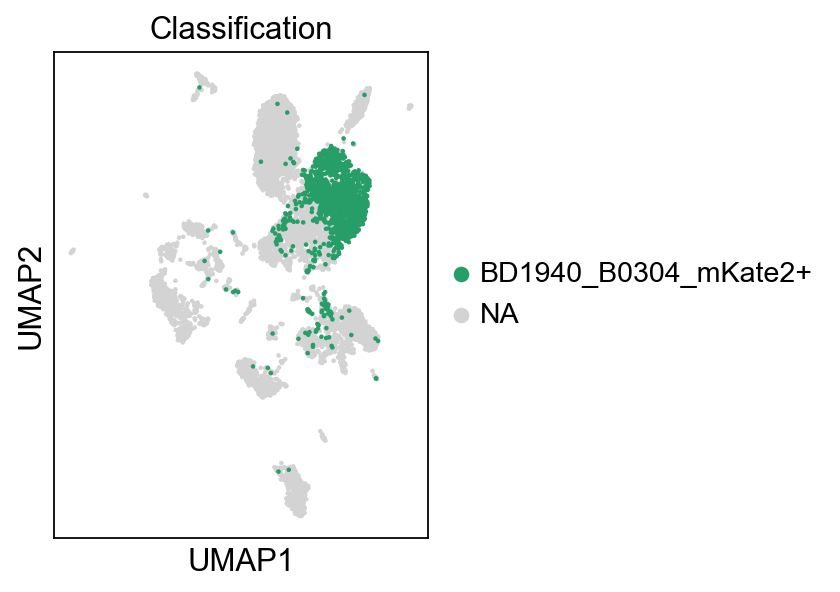

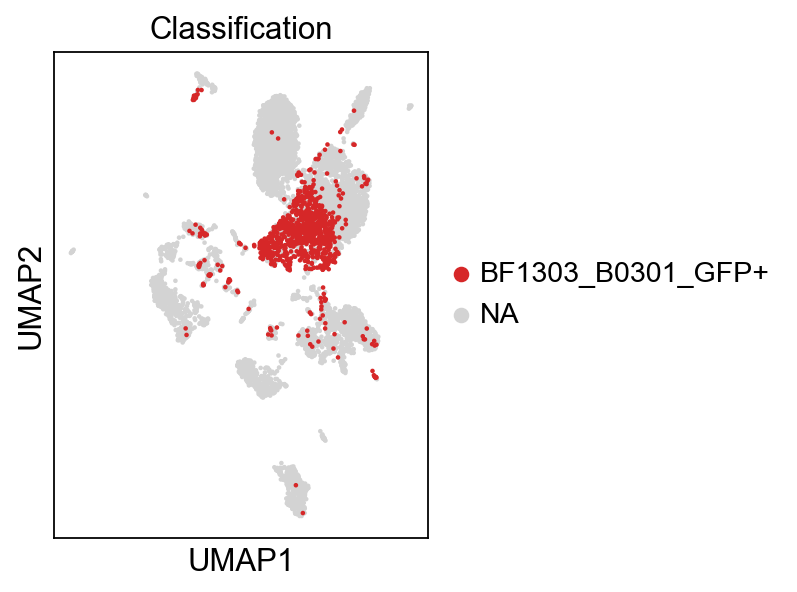

In [70]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

Cluster 1 appears to be fibroblasts based on Krt8 and Krt18 weak staining

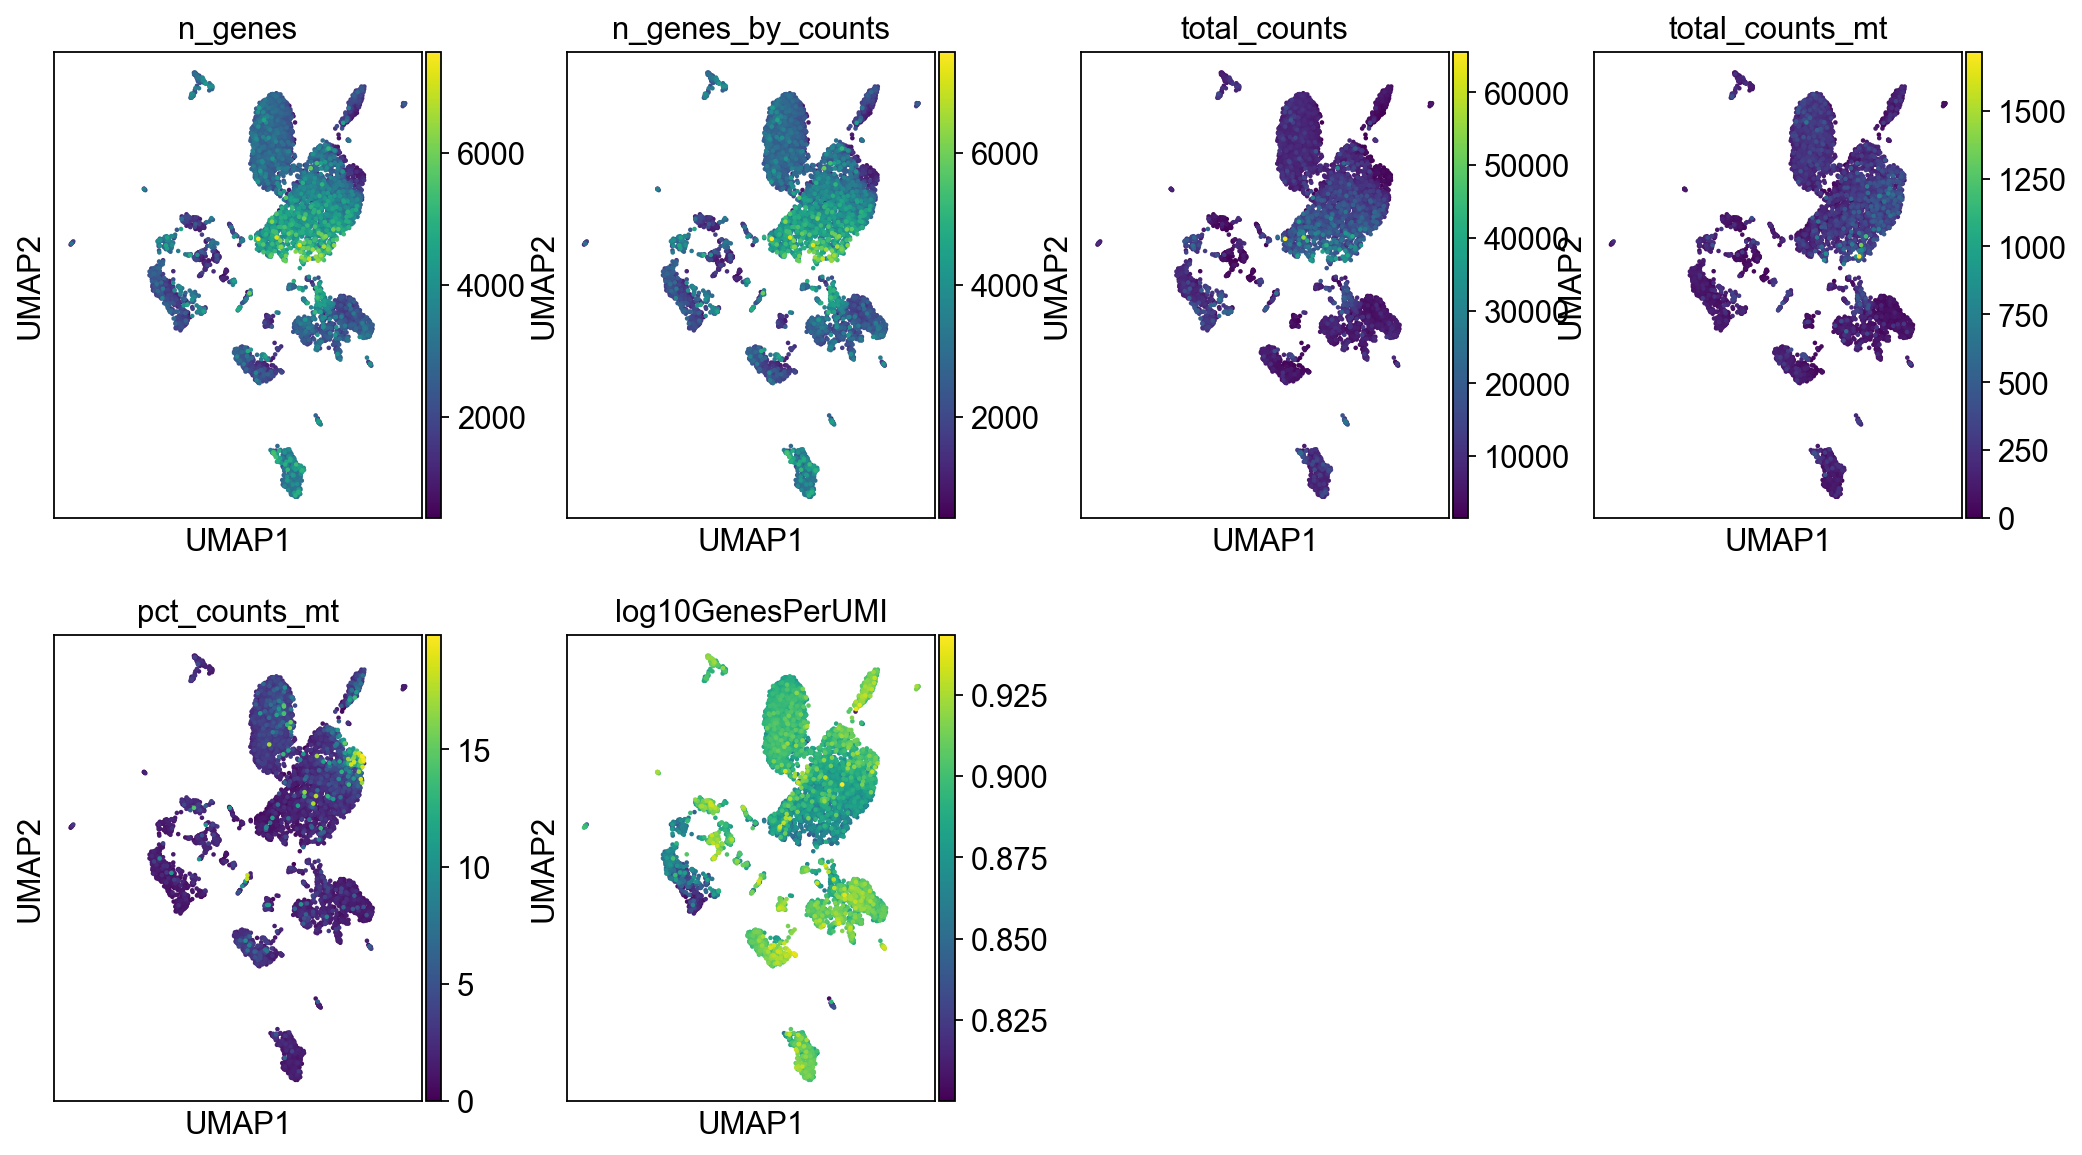

In [71]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

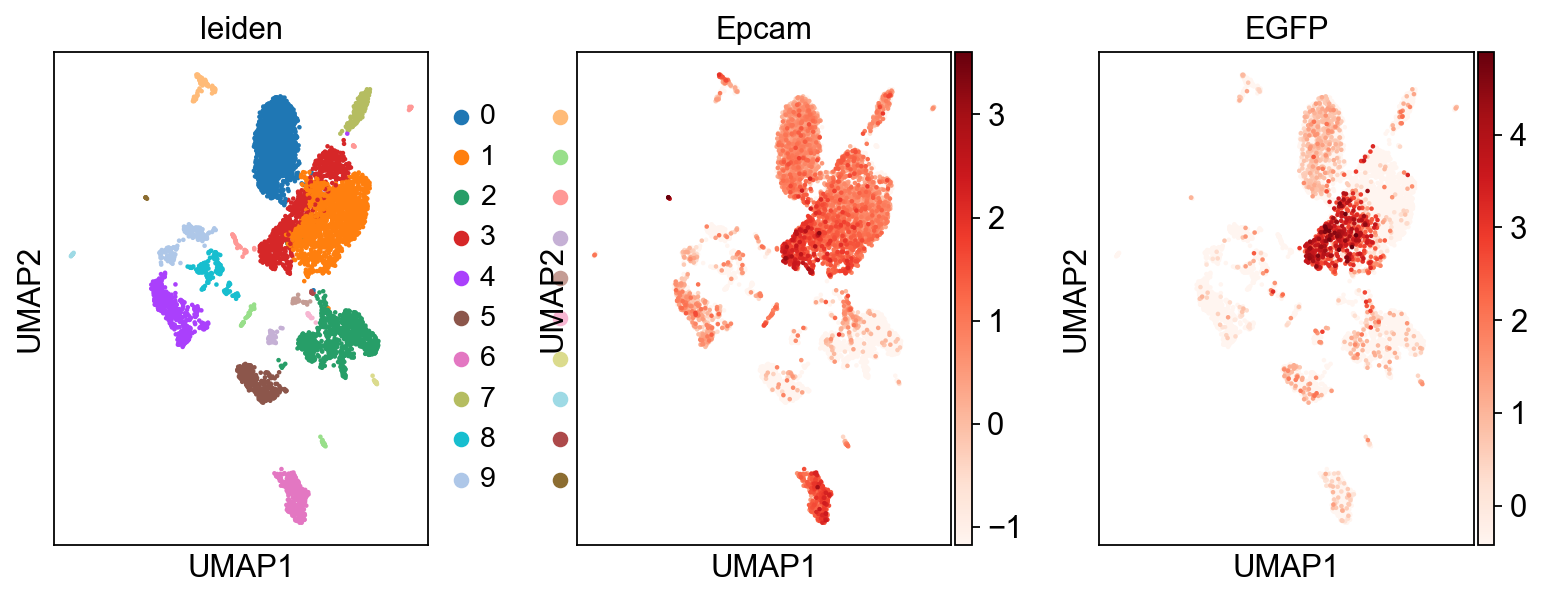

In [72]:
sc.pl.umap(adata, color=['leiden','Epcam','EGFP'],cmap="Reds")

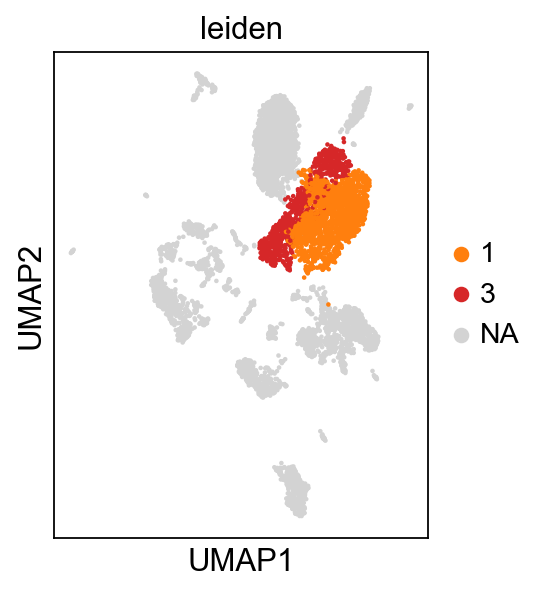

In [73]:
sc.pl.umap(adata, color=['leiden'], groups=['1','3'])

## Select tumor cells and write lane to h5ad

In [74]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO15600.h5ad')
adata = adata2[adata.obs['leiden'].isin(['1','3']),:] # keep tumor cells
del adata2

In [75]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [76]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [77]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/1697892543.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_85120/169789

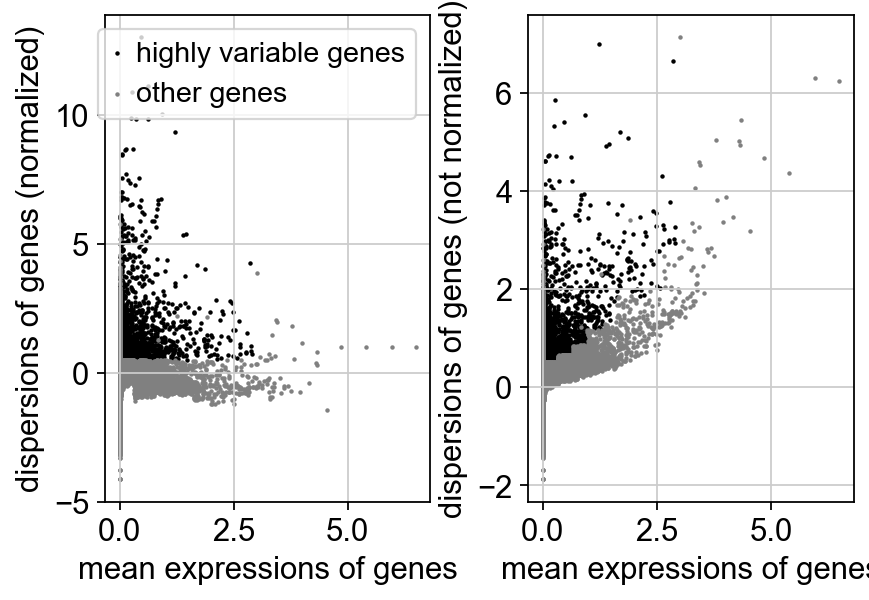

In [78]:
sc.pl.highly_variable_genes(adata)

In [79]:
adata.raw = adata

In [80]:
adata.write('write/allmice-tumor-IGO15600.h5ad', compression='gzip')
adata = sc.read('write/allmice-tumor-IGO15600.h5ad')